In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

2023-07-11 14:38:12.650694: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
plt.rcParams['figure.figsize'] = (10, 8) # set default figure size, 10in by 8in

np.set_printoptions(precision=4, suppress=True)

# Chapter 4: Getting Started with neural Networks: Classification and Regression

Supporting materials for:

Chollet (2021). *Deep Learning with Python*. 2nd ed. Manning Publications Co.
[Amazon](https://www.amazon.com/Learning-Python-Second-Fran%C3%A7ois-Chollet/dp/1617296864/ref=sr_1_1?crid=32NFM2SBCJVQQ)

The examples from this chapter show some basic end-to-end machine learning workflows.  We introduce data preprocessing,
basic model architecture principles, and model evaluation.

There are examples of classification and regression problems.  Make sure you understand the fundamental difference.
A classification problem is when we try to predict a label.  For example, the simpliest classification is binary
classification.  We will predict movie reviews where the class label of the review was either positive or negative,
this is a binary classification problem.  Classification can be more complex.  We have already seen
examples of multiclass classification with the MNIST training set.  In that case, we are trying to predict which of
10 digits each image belongs to.  This is an example of multiclass classification.

A regression problem then is one where we are trying to predict a continuous value.  A good example is predicting house
prices from house features, which we have also seen examples of so far in this class.



# 4.1 Classifying movie reviews: A binary classification example

Two-class classification, or binary classification, is one of the most common kinds of machine
learning problem.

## 4.1.1 The IMDB dataset

Another example of a test/example dataset.  The IMDB dataset has 50,000 reviews from the
Internet Movie DataBase.  They are evenly split into 25,000 reviews for training and
25,000 reviews for testing.  Also each is evenly split with 50% negative and 50% positive
reviews.

Keras has IMDB dataset packaged.  It has already been preprocessed, the reviews which are sequences
of words have been turned into sequences of integers, where each integer stands for a specific
word in the dictionary.  We would normally have to do a preprocessing step like this ourselves if
working on a new text based dataset.  But ML models can't use text as input, we have to convert text
into some numeric representation to be used as input to a ML model.

Load the dataset.

In [3]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dash/anaconda3/envs/nndl-gpu/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/dash/anaconda3/envs/nndl-gpu/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different leng

The argument `num_words=10000` means we keep only the top 10,000 most frequently occurring words in the
training data.

The variables `train_data` and `test_data` are lists of reviews.  Each review is a list of word indices.

`train_labels` and `test_labels` are our binary labels, 0 for *negative* reviews and 1 for *positive* reviews.

In [4]:
print(train_data.shape)
print(train_data.dtype)
print(train_data[0])

(25000,)
object
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Because we restriced to 10,000 most frequent words, no word index should exceed 10,000

In [5]:
max([max(sequence) for sequence in train_data])

9999

An example of decoding a review back to English words.

In [6]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# reverse the mapping, mapping integer indices to the words using the word_index dict
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]
)

# decode review 0.  Note that indices are offset by 3 because 0, 1 and 2 are reserved indices
# for "padding", "start of sequence" and "unknown"
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]
)

print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

## 4.1.2 Preparing the data

As you may have noticed, the reviews are simple lists of integers.  The reviews are of different lengths, e.g.

In [7]:
print(len(train_data[0]))
print(len(train_data[1]))

218
189


We need to process these lists into some other format to be suitable as input for a ML algorithm, like a neural network.  You can't
directly feed in uneven lists of integers.  We have to turn the lists into tensors.  Two basic methods used:

1. Pad lists so they all have the same length. e.g. turn into tensor of shape `(samples, max_length)`.
2. *Multi-hot encode* your lists to turn them into vectors of 0s and 1s.  Since we restricted to 10,000 words this would mean we
   have 10,000 features in the tensor, where a 1 indicates that word was present (maybe multiple times) in the review, and a 0 
   indicates the word was not present.  This may result in relatively sparse representations.
   
In our following example, we use approach 2.

Encoding the integer sequences via multi-hot encoding by hand.


In [8]:
def vectorize_sequences(sequences, dimension=10000):
    """Vectorize word index sequences into a multi-hot encoding.
    The sequences is n array of regular python lists.  We hot encode
    each word we find in the list into a vector of the indicated number
    of feature dimensions, one vector for each of the word sequences /
    reviews.
    """
    # initialize a tensor/array of the correct shape, initialized to all 0's
    results = np.zeros((len(sequences), dimension))
    
    # set specific index to 1 for each word index encountered in the review
    for sequence_num, sequence in enumerate(sequences):
        for word_index in sequence:
            results[sequence_num, word_index] = 1
            
    return results

# vectorize the training and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Here is what the sample inputs look like now.

In [9]:
print(x_train.shape)
print(x_train[0])

(25000, 10000)
[0. 1. 1. ... 0. 0. 0.]


We also need to vectorize the labels to get them into format needed by Keras/TensorFlow.

In [10]:
print(train_labels.dtype)
print(train_labels.shape)

y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

print(y_train.dtype)
print(y_train.shape)

int64
(25000,)
float32
(25000,)


## 4.1.3 Building your model

The input data is vectors of 10,000 features, and the output labels are scalars (1s and 0s).

A model that performs well on such a problem is a plain stack of densely connected (`Dense`) layers with
`relu` activations.  This is also known as a simple densly connected feedforward network.

Architecture decisions:

- How many layers to use
- How many (hidden) units to choose for each layer.

There are some guidelines for making good initial decisions (see chapter 5).  We start with two intermediate layers
of 16 hidden units, with a third final output layer with a single unit to perform the scalar prediction
regarding the sentiment (positive or negative) of the review.  Notice also that we use `relu` (rectified
linear unit) activation for the intermediate layers, but `sigmoid` activation for the final layer.
`sigmoid` activation is appropriate for a binary classification, as this activation squashes the output into
a value between 0 and 1.

Model definition.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

2023-07-11 14:38:20.033494: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-11 14:38:20.034343: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-11 14:38:20.062924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-11 14:38:20.063231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro M2200 computeCapability: 5.2
coreClock: 1.036GHz coreCount: 8 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 82.08GiB/s
2023-07-11 14:38:20.063270: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-11 14:38:20.064875: I tensorflow/stream_executor/platform/default/dso_loa

Recall that each `Dense` layer implements the following chain of tensor operations

```
output = relu(input @ W + b)
```

Having 16 units means the weight matrix `W` will have shape `(input_dimension, 16)`, the dot product / matrix multiplication will project the input onto a 16-dimensional representation space.  The bias vector `b` has 16 values as well which are added and then
the `relu` activation is applied.

The dimensionality can be thought of as how much freedom are you allowing the model to have.  Having more units
(higher dimensional representation space) allows mode to learn more-complex representations.  But it is more computationally
expensive.  And worse, too much freedom can lead to overfitting, which is learning noise in the specific input data.  Overfitting,
or learning these unwanted patterns, leads to improvements in predicting the data you are training with, but will most likely
decrease performance on test data, which is bad.

`relu` or rectified linear unit activation is a type of simple nonlinear transformation.  It simply zeros out
negative values.

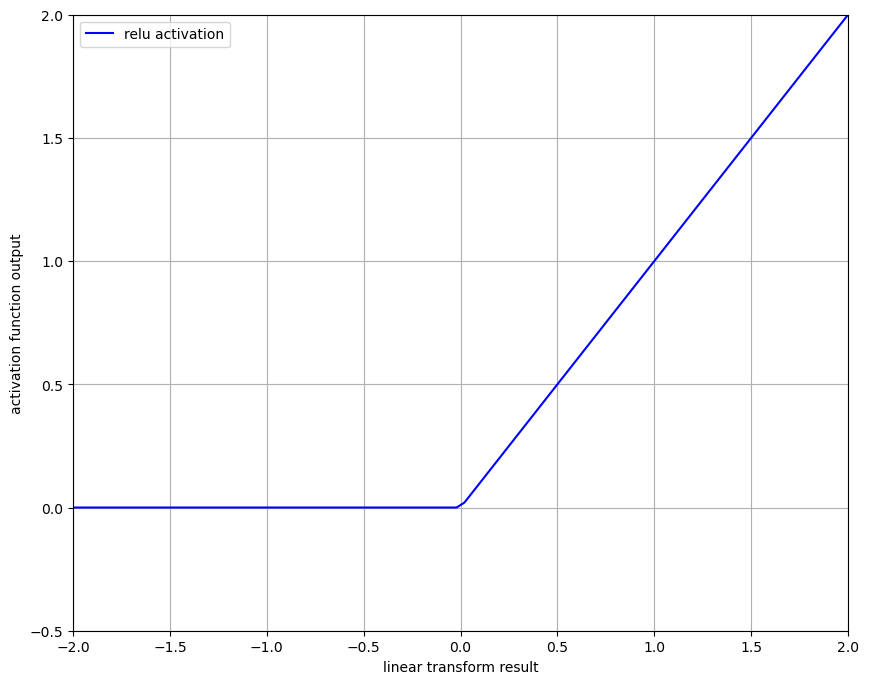

In [12]:
# relu is really the same as the max(output, 0), but we can use the tf.keras relu
from tensorflow.keras.activations import relu

linear_transform = np.linspace(-2.0, 2.0, 100)
plt.plot(linear_transform, relu(linear_transform), 'b-', label='relu activation')
plt.axis([-2, 2, -0.5, 2.0])
plt.legend()
plt.xlabel('linear transform result')
plt.ylabel('activation function output')
plt.grid();

The final layer uses a `sigmoid` activation function. The sigmoid activation is a common activation for
simple binary classification.  It squashes the output into a value between 0 and 1, and can thus
be interpreted as a probability estimate of the binary output.  When we need to make an actual decision,
we usually use a threshold of 0.5 for the final prediction of a 0 or 1 binary label.

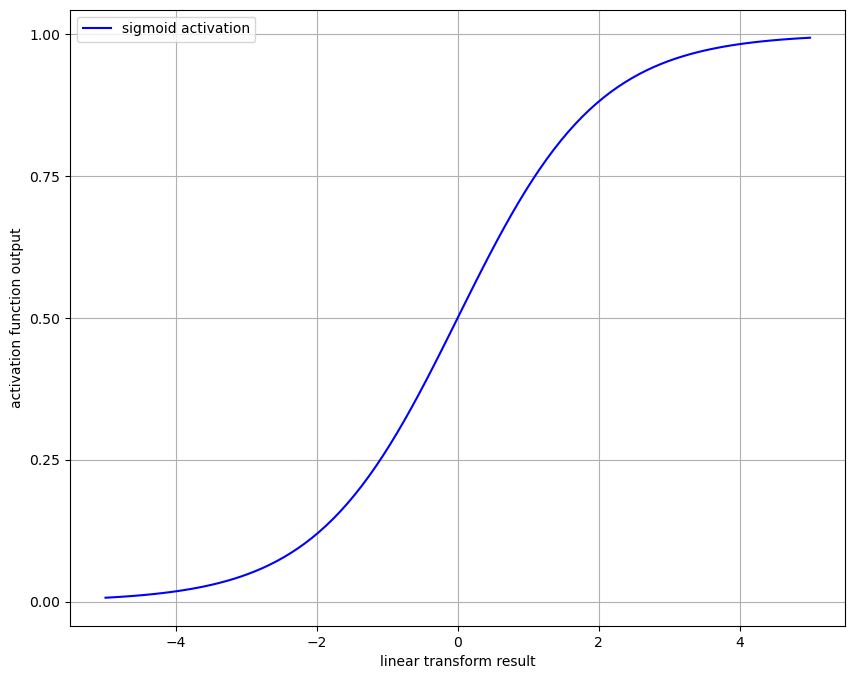

In [13]:
from tensorflow.keras.activations import sigmoid

linear_transform = np.linspace(-5.0, 5.0, 100)
plt.plot(linear_transform, sigmoid(linear_transform), 'b-', label='sigmoid activation')
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.legend()
plt.xlabel('linear transform result')
plt.ylabel('activation function output')
plt.grid();

### What are activation functions and why are they necessary?

Without an activation function like `relu` or `sigmoid` (also called a non-linearity), the `Dense`
layer would consist of two linear operations, a dot product and addition

```
output = input @ W + b
```

The layer could only perform **linear transformations** (also called affine transformations) of the input
data.  The **hypothesis space** of such a layer would be the set of all possible linear transformations of the
input data into a 16-dimensional space (assuming we use 16 units in the layer).

Linear transformations are limited.  Also multiple layers would not help, a sequence of linear transformations
is no more powerful than 1 linear transformation.

In order to get access to much richer hypothesis space that will benefit from deep representations, you need
a non-linearity in the function transformation.  `relu` is simple, but is a very popular example of
a non-linear activation function.

Finally we need a loss function and an optimizer.  

Its best to use `binary_crossentropy` loss for binary classification problems.  *Crossentropy* is a quantity 
from the field of information theory that measures the distance between probability distributions, or in
this case, between the ground-truth distribution and your predictions.

As for optimizer, we will use `rmsprop`, which is usually a good default choice for virtually
any problem.

Compiling the model

In [14]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## 4.1.4 Validating your approach

You should not evalute deep learning models (or ML models in general) on the performnce on the training data.
The real question is how well models do on data it has not been trained with and has not seen before.

It is standard practice to use a validation set to monitor accuracy of a model during training.  

Here we create a validation set by hand by setting asside 10,000 samples from the original training data
of our IMDB review dataset.

Setting aside a validation set.

In [15]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will not train for 20 epochs in mini-batches of 512 samples.  At the same time we monitor loss and
accuracy on the 10,000 validation set samples we set apart.  

Training your model.

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

2023-07-11 14:38:21.657841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-11 14:38:21.664523: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/20


2023-07-11 14:38:22.095443: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


30/30 [==============================] - 2s 34ms/step - loss: 0.6167 - accuracy: 0.6650 - val_loss: 0.4564 - val_accuracy: 0.8379
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.3665 - accuracy: 0.8948 - val_loss: 0.3219 - val_accuracy: 0.8875
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2461 - accuracy: 0.9297 - val_loss: 0.3054 - val_accuracy: 0.8785
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1962 - accuracy: 0.9416 - val_loss: 0.2750 - val_accuracy: 0.8886
Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1497 - accuracy: 0.9549 - val_loss: 0.2904 - val_accuracy: 0.8855
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1184 - accuracy: 0.9679 - val_loss: 0.2866 - val_accuracy: 0.8868
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1043 - accuracy: 0.9706 - val_loss: 0.3161 - val_accuracy: 0.8809
Epoch 8/20
30/30 [======

Note that the call to `model.fit()` returns a `History` object.  This gives a history of the training
loss and validation metrics over the epochs of training.

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

We can the loss and accuracy.  Further, we can plot training and validation history of both of these to make
inferences about how well the model training went.

In [18]:
# create list of epoch numbers for the plots
epochs = np.arange(1, len(history_dict['loss']) + 1)

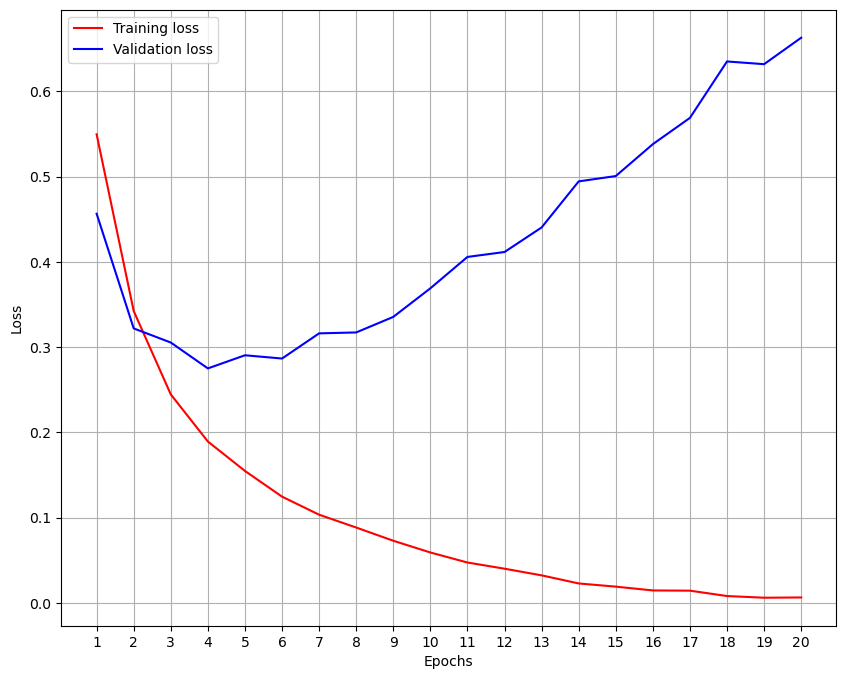

In [19]:
# plot training and validation loss.  I don't like using line and points on same plot, so change
# to using color for the two values on plot
plt.plot(epochs, history_dict['loss'], 'r-', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid()
plt.legend();

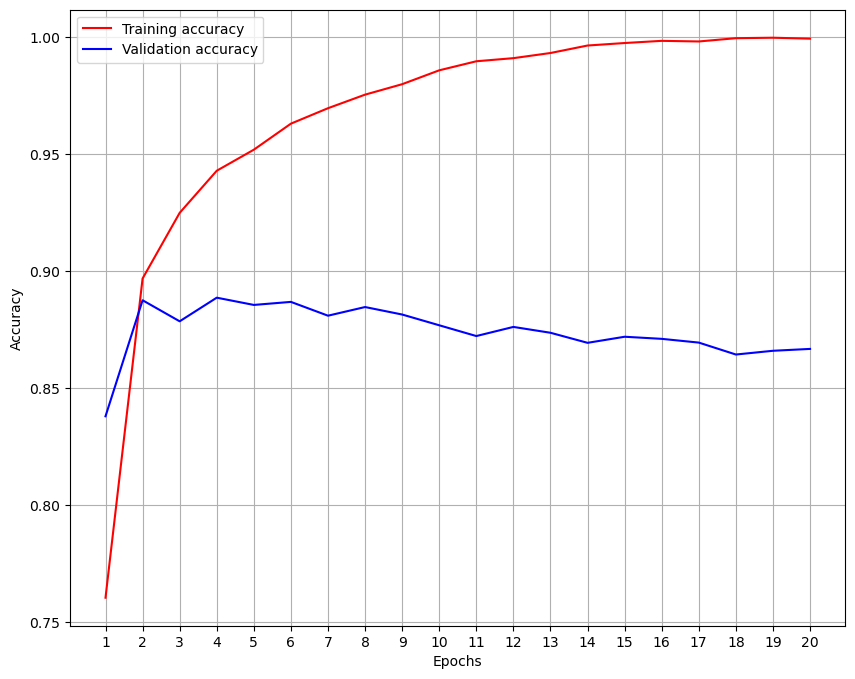

In [20]:
# plot training and validation accuracy 
plt.plot(epochs, history_dict['accuracy'], 'r-', label='Training accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'b-', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid()
plt.legend();

As you can see, training loss decreases with each epoch of training, and training accuracy improves.

However, validation loss gets worse and accuracy does not improve nor is it ever as good as training accuracy.

This model performs much better on the training data than on the validation data.  

This is an example of **overfitting**.  After the 4th epoch validation loss stops decreasing.  We are
overoptimizing on the training data and end up learning representations that are specific to
the training data (noise) and don't generalize.

Can use a range of techniques to mitigate overfitting.  Simplest approach is to stop training when
validation loss starts increasing, e.g. for only 4 epochs.

Retraining a model from scratch for 4 epochs to stop before overfitting.

In [21]:
model = keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(1, activation="sigmoid")
])

# train the model for 4 epochs
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)


# determine results on the test data, first number is the test loss
# and second is the accuracy
results = model.evaluate(x_test, y_test)
print(results)


Epoch 1/4
49/49 [==============================] - 1s 7ms/step - loss: 0.5891 - accuracy: 0.7147
Epoch 2/4
49/49 [==============================] - 0s 7ms/step - loss: 0.3072 - accuracy: 0.9057
Epoch 3/4
49/49 [==============================] - 0s 7ms/step - loss: 0.2155 - accuracy: 0.9284
Epoch 4/4
782/782 [==============================] - 1s 1ms/step - loss: 0.2838 - accuracy: 0.8874
[0.2837695777416229, 0.887440025806427]


This naive approach achieves an accuracy of about 87%.  State-of-the-art approaches should be able to get close to 95% accuracy
on test data.

## 4.1.5 Using a trained model to generate predictions on new data

Can use `predict` method of trained model to generate predictions on new data.

In [22]:
model.predict(x_test)

array([[0.284 ],
       [0.9999],
       [0.8844],
       ...,
       [0.1345],
       [0.0924],
       [0.649 ]], dtype=float32)

## 4.1.6 Further experiments

Left as an exercise for students.  See if you can improve the model.

- Try more representation layers
- Try more or fewer units in layers
- Try using `mse` loss instead of `binary_crossentropy`
- Try using `tanh` activation instead of `relu`.

## 4.1.7 Wrapping up

- Usually need to do quite a bit of preprocessing.
- Stacks of `Dense` layers with `relu` activations can solve a wide range of problems.
- In binary classification, model should end with a `Dense` layer with one unit using `sigmoid` activation.
- Should usually use `binary_crossentropy` loss function for scalar sigmoid output on binary classification problems.
- The `rmsprop` optimizer is generally good enough for most nn/deep learning problems.
- Neural networks eventually start overfitting and get increasingly worse at generalizing to unseen data.  Need to always
  fight overfitting and monitor performance.

# 4.2 Classifying newswires: A multiclass classification example.

When we have more than 2 (binary) classes, we will be doing **multiclass classification**.  More specificaly this is known
as **single-label multiclass classification**.

## 4.2.1 The Reuters dataset

This dataset is also textual.  It consists of news articles.  The label we are trying to predict from the text
is the topic or area of the news article (like finance, sports, politics), etc.

The Reuters dataset is available from keras.

Loading the Reuters dataset.

In [23]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

/home/dash/anaconda3/envs/nndl-gpu/lib/python3.9/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/dash/anaconda3/envs/nndl-gpu/lib/python3.9/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [24]:
# there are 8,982 training examples and 2,246 test examples
print(train_data.shape)
print(test_data.shape)

(8982,)
(2246,)


As with the IMDB reviews, each sample is a list of integers, which are word indices of a word dictionary for the
articles.

In [25]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here is how you can decode it back to words again.

In [26]:
word_index = reuters.get_word_index()

reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]
)

decoded_newswire = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[10]]
)

print(decoded_newswire)

? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3


The label is an integer between 0 and 45, a topic index.

In [27]:
train_labels[10]

3

## 4.2.2 Preparing the data

You can vectorize the data with the exact same code as in previous example.

Encoding the input data.

In [28]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

There are two ways to vectorize the labels.  We can cast the label list as an integer tensor.  Or we can use
**one-hot encoding**.  One-hot encoding is a widely used format for categorical data, it is also sometimes
called **categorical encoding**.  In this case, one-hot encoding of the labels consists of embedding each label
as an all-zero vector with a 1 in the place of the correct label index.

Encoding the labels.

In [29]:
def to_one_hot(labels, dimension=46):
    """A hand-made implementaiton of one-hot
    encoding.  Given integer labels, reencode as one-hot
    encoded vector.  We assume 46 dimensions of the
    reuters output category labels.  The resulting shape
    of the labels is (num_samples, 46) where each of the
    46 features is a 0 or 1 value, and only one value is 
    encoded as 1, which is the correct category for that sample.
    """
    # create resulting one-hot encoded labels, initialized to all 0's
    # initially
    results = np.zeros((len(labels), dimension))
    
    for sample_num, label in enumerate(labels):
        results[sample_num, label] = 1.0
    return results

# one-hot encode the train and test labels
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

print(y_train.shape)
print(y_train[0])

(8982, 46)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


We don't really need to write encodings like this by hand.  Usually libraries like
`scikit-learn` and `tensorflow.keras` will have premade functions for common tasks
like this.

In [30]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

print(y_train.shape)
print(y_train[0])

(8982, 46)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## 4.2.3 Building your model

The news article classification problem is similar to our first binary classification problem.  The input is encoded in the
same way.

But the number of outputs has changed from 1 binary labels of 0 or 1, to 46 outputs of 0 or 1, where only 1 of the 46 should be 1
to indicate the predicted category of the news article.

A 16-dimensional space may be too limited to separate 46 different classes.  Such small layers act as information bottlenecks.

For this reason, we may anticipate we need to use larger layers.

Model definition.

In [31]:
model = keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(46, activation="softmax")
])

Notice we end the model with a `Dense` layer with 46 dimensions/outputs this time (one for each one-hot
encoded output we want to predict).

Second we use `softmax` activation for the final output layer.  `softmax` activation outputs
a **probability distribution** over the 46 different output classes.  For each sample, the model
produces a 46-dimensional output vector, where the `output[i]` is the probability that the sample 
belongs to class `i`.  Since this is a probability distribution, the 46 scores will sum up to 1,
this is part of what `softmax` does.

The best loss function to use is probably `categorical_crossentropy`.  As the name implies this loss
is good for categorical (multiclass) outputs.

Compiling the model.

In [32]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

## 4.2.4 Validating your approach

Lets again split off some of the training data to use for validation while fitting the model.

Setting aside a validation set.

In [33]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

Now we will train for 20 epochs, using batchs of 512 samples.

In [34]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 21ms/step - loss: 2.9645 - accuracy: 0.4472 - val_loss: 1.6387 - val_accuracy: 0.6370
Epoch 2/20
16/16 [==============================] - 0s 10ms/step - loss: 1.4429 - accuracy: 0.6931 - val_loss: 1.2821 - val_accuracy: 0.7130
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 1.0645 - accuracy: 0.7787 - val_loss: 1.1350 - val_accuracy: 0.7520
Epoch 4/20
16/16 [==============================] - 0s 11ms/step - loss: 0.8242 - accuracy: 0.8267 - val_loss: 1.0285 - val_accuracy: 0.7890
Epoch 5/20
16/16 [==============================] - 0s 10ms/step - loss: 0.6582 - accuracy: 0.8633 - val_loss: 0.9693 - val_accuracy: 0.8070
Epoch 6/20
16/16 [==============================] - 0s 12ms/step - loss: 0.5170 - accuracy: 0.8901 - val_loss: 0.9490 - val_accuracy: 0.8030
Epoch 7/20
16/16 [==============================] - 0s 11ms/step - loss: 0.4107 - accuracy: 0.9109 - val_loss: 0.9176 - val_accuracy: 0.8150
Epoch 8/20
16

And finally let's display th eloss and accuracy curves again.  Since this is the second time using the same
code to plot these figures, lets take a bit of time to create functions we can reuse instead so we can do these
plots without copying the plotting code again and again.

In [35]:
def plot_loss_curves(history):
    """Plot training and validation loss.  I don't like using line and points on same plot, so change
    to using color for the two values on plot
    """
    # extract the data to plot
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = np.arange(1, len(loss) + 1)
    
    # plot the loss curves
    plt.plot(epochs, loss, 'r-', label='Training loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid()
    plt.legend();

In [36]:
def plot_accuracy_curves(history):
    """Plot training and validation accuracy
    """
    # extract the data to plot
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # plot the accuracy curves
    plt.plot(epochs, acc, 'r-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.grid()
    plt.legend();

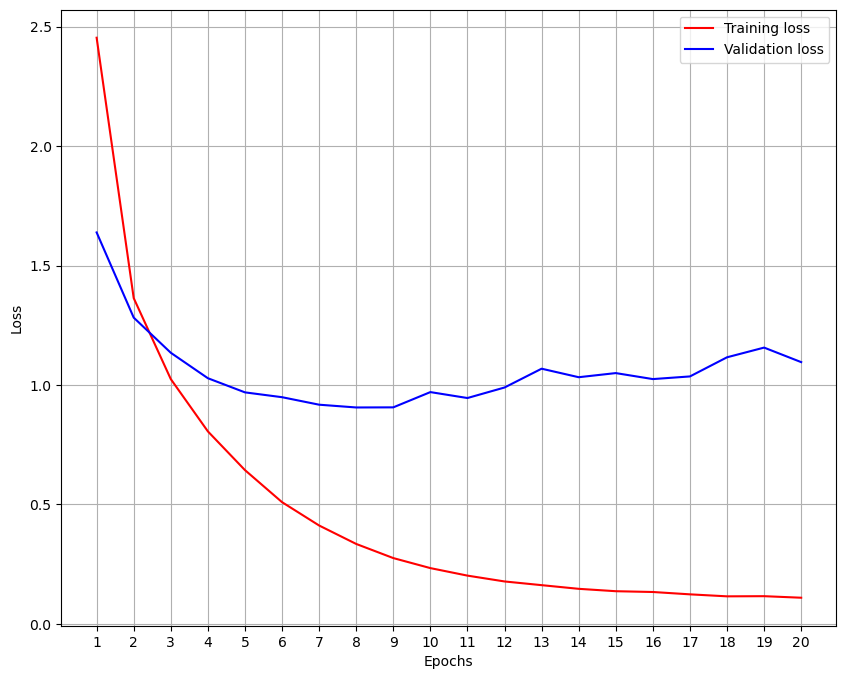

In [37]:
plot_loss_curves(history)

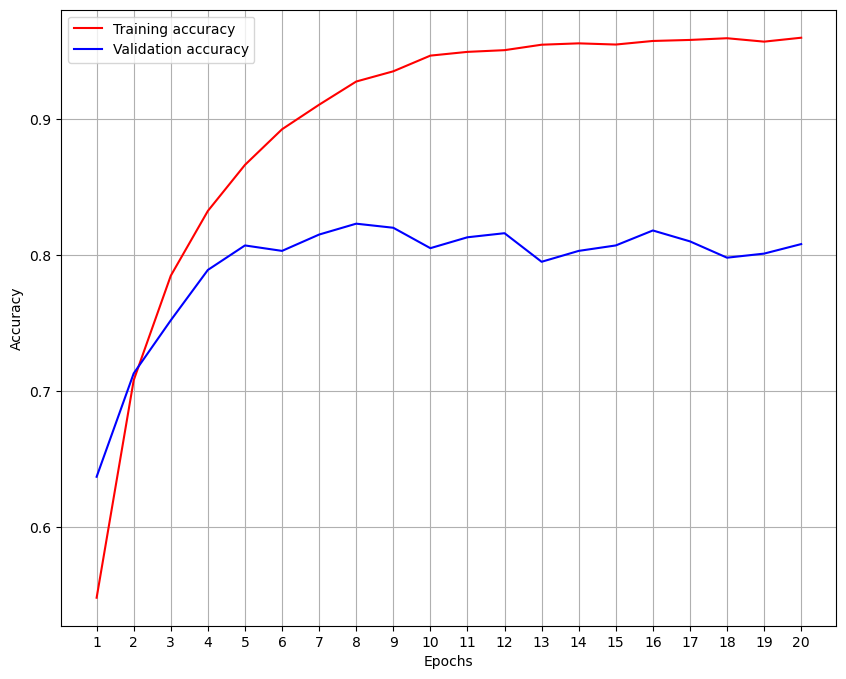

In [38]:
plot_accuracy_curves(history)

The model begins to overfit after 8 or 9 epochs, topping out at about just above 80% accuracy.

As before, we take a brute force method to avoid overfitting, and just retrain from
scratch and stopping before we saw the overfitting.

Retraining a model from scratch and stopping before overfitting.

In [39]:
# create the same model from scratch
model = keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(46, activation="softmax")
])


# compile model with same loss and optimizer
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# fit model stopping after 9 epochs of training
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)

# jump to directly evaluating results on the test data of this model
results = model.evaluate(x_test, y_test)

print(results)

Epoch 1/9
18/18 [==============================] - 0s 8ms/step - loss: 3.2009 - accuracy: 0.4091
Epoch 2/9
18/18 [==============================] - 0s 8ms/step - loss: 1.4790 - accuracy: 0.7023
Epoch 3/9
18/18 [==============================] - 0s 9ms/step - loss: 1.0502 - accuracy: 0.7754
Epoch 4/9
18/18 [==============================] - 0s 9ms/step - loss: 0.8194 - accuracy: 0.8280
Epoch 5/9
18/18 [==============================] - 0s 8ms/step - loss: 0.6334 - accuracy: 0.8695
Epoch 6/9
18/18 [==============================] - 0s 8ms/step - loss: 0.4965 - accuracy: 0.8991
Epoch 7/9
18/18 [==============================] - 0s 8ms/step - loss: 0.3905 - accuracy: 0.9187
Epoch 8/9
18/18 [==============================] - 0s 9ms/step - loss: 0.3182 - accuracy: 0.9324
Epoch 9/9
71/71 [==============================] - 0s 2ms/step - loss: 0.9547 - accuracy: 0.7952
[0.9547301530838013, 0.7951914668083191]


This approach will usually reach an accuracy of about 80%. 

This is more impressive than before.  With a balanced binary classification, the accuracy of purely random
guessing would be 50%.  But here random guessing only achieves `1 / 46 =` about 2% accuracy.

It is always a good idea to have in mind the performance of a random baseline.  We can
create such a random baseline and check empirically:


In [40]:
import copy

# copy and randomly shuffle up the labels.  This better simulates random guessing here,
# which ends up higher than 1/46 because the labels are not evenly distributed in this
# test data
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)

# count up number of times the random guess/shuffle gets answer correct
hits_array = np.array(test_labels) == np.array(test_labels_copy)

hits_array.mean()

0.18210151380231523

So actually, unlike what I just said above, a better random guesser would get about 20% accuracy.  This random
basiline is a better guesser because, the categories are not equally distributed.  So the random guesser should guess
the larger categories more frequently than the smaller represented news article categories.  Using a random shuffle
maintains the frequence of the categories, and thus acts as a random guesser biased to guess at the same frequency
of the category labels.

In any case, a model getting 80% here is still better than you might have initially thought, given the problem is much
tougher here than before.

## 4.2.5 Generating predictions on new data

Calling `predict` with a trained model on new samples returns a class probability ditribution over all 46 topics.  

We can generate topic predictions for all of the test data.

In [41]:
predictions = model.predict(x_test)

Each entry in `predictions` is a vector of length 46 that sums up to 1.0.  You can think of the value as the probability that
the test sample article is of each of the 46 topic categories.

In [42]:
predictions[0].shape

(46,)

In [43]:
print(predictions[0])
print(np.sum(predictions[0]))
print(y_test[0])
print(test_labels[0])

[0.     0.     0.     0.9748 0.0175 0.     0.     0.0001 0.0023 0.
 0.     0.     0.0001 0.0009 0.     0.     0.0011 0.     0.     0.0003
 0.0004 0.0002 0.     0.0002 0.     0.0001 0.     0.0002 0.     0.0002
 0.     0.0004 0.     0.     0.     0.     0.0002 0.     0.     0.0002
 0.     0.     0.0002 0.     0.     0.    ]
0.99999976
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3


The largest entry should be chosen as the predicted class.  As should usually be the case, you should see that topic 3 has the
largest predicted value, around 0.7133, and thus topic 3 would be the predicted topic for the test article 0.

We can use argmax to convert the one-hot encoding back to an integer topic index.

In [44]:
np.argmax(predictions[0])

3

## 4.2.6 A different way to handle the labels and the loss

We mentioned that the labels could also be cast as an integer tensor.

In [45]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(y_train.shape)
print(y_train)

(8982,)
[ 3  4  3 ... 25  3 25]


The only thing this approach would change is the choice of the loss function.  The loss function `categorical_crossentropy`
expects the labels to follow a categorical encoding.  With integer labels you should use `sparse_categorical_crossentropy`

In [46]:
# lets show complete example of using integer encoding and this different loss function.
# build model from scratch
model = keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(46, activation="softmax")
])

# compile model specifying this different loss function
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# we have different y data labels, so pull out validation data again
#x_val = x_train[:1000]
#partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

# fit the model
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 20ms/step - loss: 3.1265 - accuracy: 0.4204 - val_loss: 1.6931 - val_accuracy: 0.6550
Epoch 2/20
16/16 [==============================] - 0s 10ms/step - loss: 1.4655 - accuracy: 0.6976 - val_loss: 1.2864 - val_accuracy: 0.7170
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 1.0690 - accuracy: 0.7669 - val_loss: 1.1378 - val_accuracy: 0.7560
Epoch 4/20
16/16 [==============================] - 0s 11ms/step - loss: 0.8418 - accuracy: 0.8172 - val_loss: 1.0340 - val_accuracy: 0.7730
Epoch 5/20
16/16 [==============================] - 0s 10ms/step - loss: 0.6535 - accuracy: 0.8681 - val_loss: 0.9951 - val_accuracy: 0.7950
Epoch 6/20
16/16 [==============================] - 0s 11ms/step - loss: 0.5118 - accuracy: 0.8917 - val_loss: 0.9274 - val_accuracy: 0.7970
Epoch 7/20
16/16 [==============================] - 0s 11ms/step - loss: 0.4089 - accuracy: 0.9170 - val_loss: 0.9234 - val_accuracy: 0.7960
Epoch 8/20
16

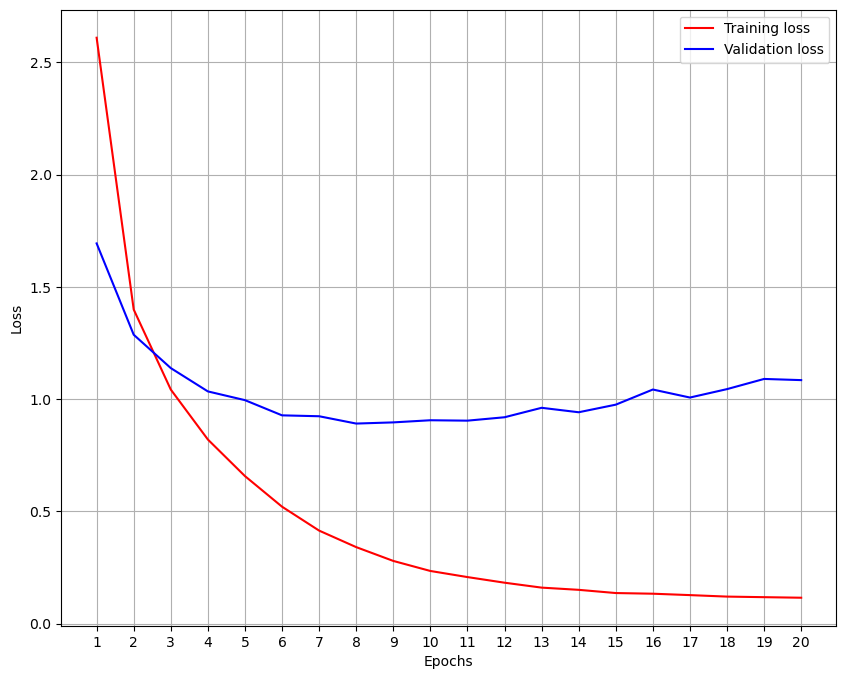

In [47]:
plot_loss_curves(history)

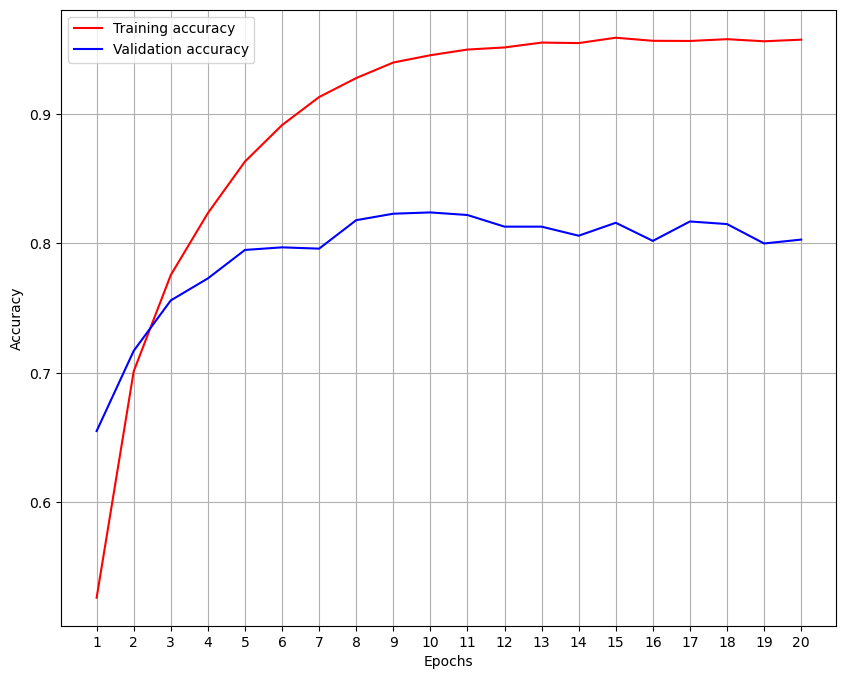

In [48]:
plot_accuracy_curves(history)

The new loss function is still mathematically the same as `categorical_crossentropy`, it just has
a different interface.  Results from train are about the same here.

## 4.2.7 The importance of having sufficiently large intermediate layers

Lets introduce an information bottleneck.  Second layer is reduced to only 4 units.

A model with an information bottleneck.

In [49]:
# lets first revert back to one-hot categorical encoded labels and using categorical_crossentropy
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

# also resplit the validation data again
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [50]:
# create model with a bottleneck
model = keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(4, activation="relu"),
            layers.Dense(46, activation="softmax")
])

# back to categorical_crossentropy for the categorical encoding
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# fit the model
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 7ms/step - loss: 3.3420 - accuracy: 0.2673 - val_loss: 2.1552 - val_accuracy: 0.5680
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 1.7958 - accuracy: 0.6382 - val_loss: 1.5869 - val_accuracy: 0.6470
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 1.3774 - accuracy: 0.6864 - val_loss: 1.4378 - val_accuracy: 0.6740
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.1526 - accuracy: 0.7226 - val_loss: 1.4041 - val_accuracy: 0.6870
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0103 - accuracy: 0.7521 - val_loss: 1.3661 - val_accuracy: 0.7000
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 0.8894 - accuracy: 0.7786 - val_loss: 1.3462 - val_accuracy: 0.6980
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.8487 - accuracy: 0.7774 - val_loss: 1.3842 - val_accuracy: 0.6910
Epoch 8/20
63/63 [==

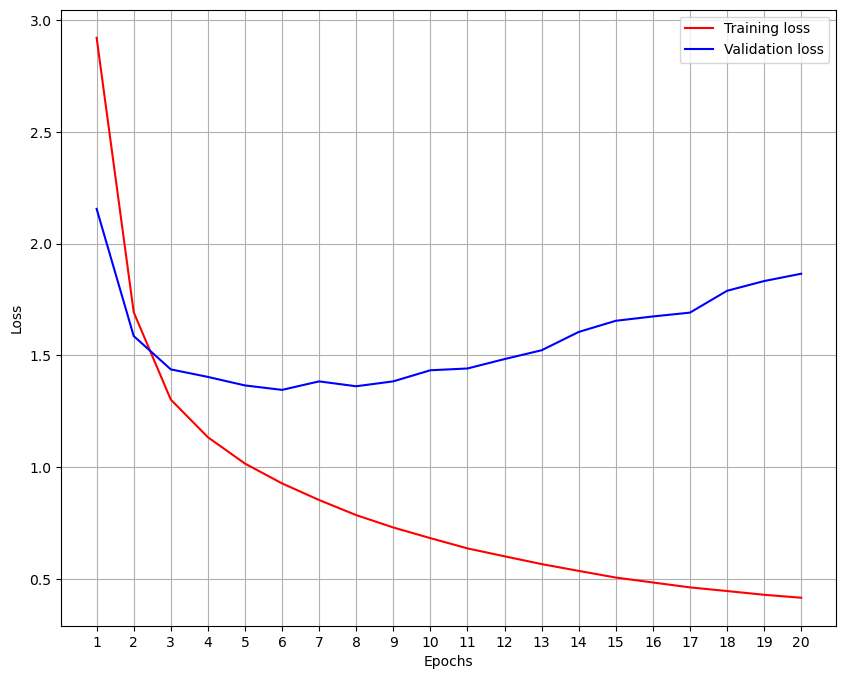

In [51]:
plot_loss_curves(history)

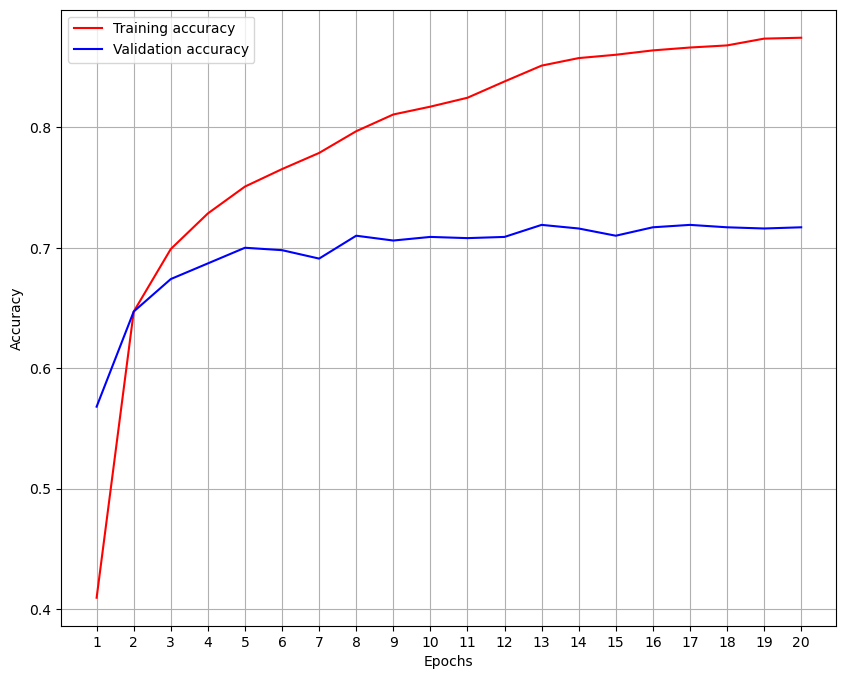

In [52]:
plot_accuracy_curves(history)

The model shows that the best validation accuracy is around 72%, an 8% drop.  This is mostly due
to fact we are compressing a lot of information into an intermediate space that is too low-dimensional.

## 4.2.8 Further Experiments

Left as an exercise for the student.  Try and improve the performance of this multiclass classification model.  Try the following

- Try using larger or smaller layers.
- Try using more or less intermediate layers.

## 4.2.9 Wrapping up

- If classifying among N classes (multiclass classification), should end with a `Dense` layers of size N
- For single-lable multiclass classification, us a `softmax` activation to get a probability distribution over the N output classes.
- Categorical crossentropy is usual loss function for such problems.
- Two ways to handle labels
  - Encode via categorical encoding (one-hot encoding) and use `categorical_crossentropy` loss function.
  - Encode labels as integers and use `sparse_categorical_crossentropy` loss function.
- If you need to classify data into a large number of categories, avoid information bottlenecks in your model layers.


Also as we saw above, if using integer labels, you actually still need a N sized `softmax` output layer.  The crossentropy
loss computes loss between the category and the N sized probability distribution.